# Algoritmus SIMPLE pro Navierovy-Stokesovy rovnice

In [1]:
using PyPlot;

In [2]:
include("mesh.jl");
include("fields.jl");
include("operators.jl");

In [3]:
function div(ϕ::Array{Float64,1} , U::Field)
    A = spzeros(length(U.values),length(U.values))
    b = zeros(U.values)
    
    msh = U.mesh
    
    for f ∈ msh.faces
        o = f.owner
        n = f.neigh
    
        α = max(ϕ[f.id], 0.0)
        β = min(ϕ[f.id], 0.0)
        
        A[o,o] += α / msh.cells[o].vol
        A[o,n] += β / msh.cells[o].vol
            
        A[n,o] -= α / msh.cells[n].vol
        A[n,n] -= β / msh.cells[n].vol
    end

    for (name,faces) ∈ msh.patches
        bc = U.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            coeff = boundary_coeffs(bc, i)  # tj. ub = coef[1] + coef[2]*uin
            α = max(ϕ[f.id], 0.0)
            β = min(ϕ[f.id], 0.0)

            c = boundary_coeffs(bc, i)  # tj. ub = c[1] + c[2]*uin
            A[o,o] += (α + β*c[2]) / msh.cells[o].vol
            b[o]   += β*c[1] / msh.cells[o].vol
        end
    end

    
    return Equation(A, U.values, b)
end     

div (generic function with 1 method)

In [4]:
function create_fields(msh)
    U = VectorField(msh)
    set_dirichlet_patch!(U, "left", Vec2d(0,0));
    set_dirichlet_patch!(U, "right", Vec2d(0,0));
    set_dirichlet_patch!(U, "bottom", Vec2d(0,0));
    set_dirichlet_patch!(U, "top", Vec2d(1,0));

    p = ScalarField(msh);
    for name ∈ ["left", "right", "bottom", "top"]
        set_neumann_patch!(p, name, 0.0)
    end

    return (U,p)
end;

In [5]:
function interpolate_U_to_faces(U::VectorField)
    mesh = U.mesh
    nfaces = length(mesh.faces) + reduce(+, [length(faces) for (_,faces) ∈ mesh.patches])
    ϕ = zeros(nfaces)
    for f ∈ mesh.faces
        o = f.owner
        n = f.neigh
        ϕ[f.id] = dot(f.s, (U[o]+U[n])/2.)
    end

    for (name,faces) ∈ mesh.patches
        bc = U.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            Ub = boundary_value(bc, i)
            ϕ[f.id] = dot(f.s, Ub)
        end
    end

    return ϕ
end

interpolate_U_to_faces (generic function with 1 method)

In [6]:
function calculate_ϕ!(ϕ::Array{Float64,1}, Ubar::VectorField, p::ScalarField, ra::Array{Float64,1})
    mesh = Ubar.mesh
    nfaces = length(mesh.faces) + reduce(+, [length(faces) for (_,faces) ∈ mesh.patches])
    for f ∈ mesh.faces
        o = f.owner
        n = f.neigh
        δ = norm(mesh.cells[n].x - mesh.cells[o].x)
        pn = (p[n] - p[o]) / δ
        ϕ[f.id] = dot(f.s, (Ubar[o]+Ubar[n])/2.) - (ra[o]+ra[n])/2 * pn * norm(f.s)
    end

    for (name,faces) ∈ mesh.patches
        bc  = Ubar.boundaries[name]
        pbc = p.boundaries[name]
        for (i,f) ∈ enumerate(bc.faces)
            o = f.owner
            Ub = boundary_value(bc, i)
            pb = boundary_value(pbc, i)
            pn = (pb - p[o]) / norm(mesh.cells[o].x - f.x)
            ϕ[f.id] = dot(f.s, Ub) - ra[o] * pn
        end
    end

end

calculate_ϕ! (generic function with 1 method)

In [7]:
function SIMPLE(U, p, ν; fix_pressure=true, iters=50)
    mesh = U.mesh
    α = 0.7
    β = 0.3

    ϕ = interpolate_U_to_faces(U)

    for iter = 0:iters
    
        UOld, pOld = copy(U.values), copy(p.values)
    
        
        UEqn = div(ϕ,U) - Δ(ν,U)

        relax!(UEqn, α)
    
        solve!(UEqn + ∇(p))
    
        ra = 1 ./ Ac(UEqn);

        Ubar = VectorField(ra .* H(UEqn), U.mesh, U.boundaries);
    
        pEqn = Δ(ra, p) - ∇(Ubar);
        if fix_pressure
            pEqn.A[1,1] -= length(mesh.cells)
        end
        solve!(pEqn)
    
        p ← β*p + (1-β)*pOld
        U ← Ubar - ra .* ∇(p)
    
        calculate_ϕ!(ϕ, Ubar, p, ra)
        
        if rem(iter,5)==0
            nxny = length(mesh.cells)
            pRez = norm(pOld - p.values) / nxny
            URez = norm(UOld - U.values) / nxny
            println(iter, "\t", pRez, "\t", URez)
        end

    end
    
    return U,p
end

SIMPLE (generic function with 1 method)

In [8]:
function cavity_ns(ν, mesh)

    U,p = create_fields(mesh);
    U,p = SIMPLE(U, p, ν)
    return U,p
end

cavity_ns (generic function with 1 method)

In [9]:
ν = 0.01;
msh25 = cartesian_mesh(25,25);
U,p = cavity_ns(ν, msh25);

0	0.003954386650172494	0.0031633014957489257
5	0.0009313427996707679	0.0005820193295719034
10	0.00013548980578324083	0.00025506876833372857
15	0.00017847248003570733	0.00015129097069981434
20	0.00010612779116952029	0.00010613746710153291
25	4.453713224425754e-5	7.86657676718023e-5
30	1.7553394031891265e-5	5.997548804401457e-5
35	9.89568527159458e-6	4.658787470759559e-5
40	7.548678374520902e-6	3.66352814513692e-5
45	6.3536038398324255e-6	2.902663057372061e-5
50	5.382903568870426e-6	2.3096888945097248e-5


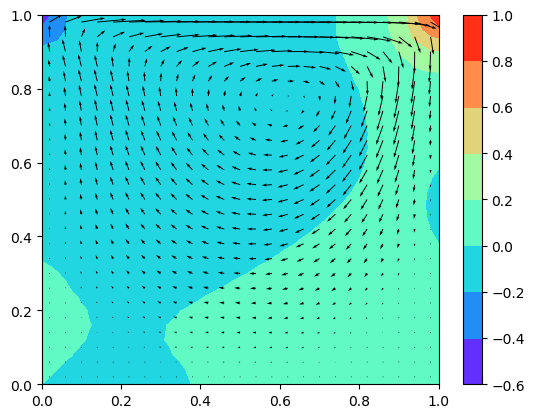

In [10]:
cmap = ColorMap("rainbow")

plot_contourf(p; cmap=cmap); colorbar();
plot_arrows(U);

## Jemnější síť a menší viskozita

In [11]:
ν = 1.e-3;
msh50 = cartesian_mesh(50,50);

In [12]:
U,p = cavity_ns(ν, msh50);

0	0.00039379457172870056	0.0011611564177153371
5	0.0001336644019491195	0.00018143208796904636
10	2.229342553582052e-5	0.0001059981922056072
15	1.9249245570140393e-5	8.185950976471167e-5
20	1.7066576891443028e-5	7.089598420492302e-5
25	1.2710589849244858e-5	6.466429272635907e-5
30	1.0287541290041003e-5	6.041337521272531e-5
35	9.037281288736119e-6	5.663356601918006e-5
40	8.260620382086677e-6	5.300219114514988e-5
45	7.65675008987798e-6	4.947518798854883e-5
50	7.113138719415052e-6	4.6047261110254174e-5


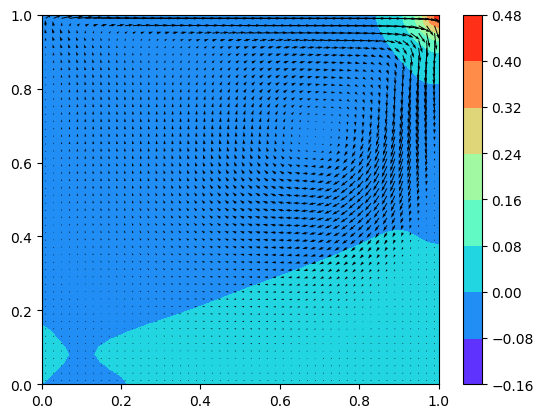

In [13]:
plot_contourf(p; cmap=cmap); colorbar();
plot_arrows(U);

In [14]:
component(f::VectorField, c) = [ v[c] for v in f.values ]

n=50
uu = reshape(component(U,1), (n,n));
vv = reshape(component(U,2), (n,n));
pp = reshape(p.values, (n,n));

In [15]:
# Ψ_x = v, Ψ_y = - u

function streamfunction(u, v, Δx=1, Δy=1)
    Ψ1 = zeros(u)

    Ψ1[1,1] = 0.0
    for i=2:size(u,1)
        Ψ1[i,1] = Ψ1[i-1,1] + Δx * (v[i,1]+v[i-1,1])/2
    end
    for j=2:size(u,2)
        Ψ1[:,j] = Ψ1[:,j-1] - Δy * (u[:,j]+u[:,j-1])/2
    end

    Ψ2 = zeros(Ψ1)
    
    Ψ2[1,1] = 0.0
    for j=2:size(u,2)
        Ψ2[1,j] = Ψ2[1,j-1] - Δy * (u[1,j,1]+u[1,j-1])/2
    end
    for i=2:size(u,1)
        Ψ2[i,:] = Ψ2[i-1,:] + Δx * (v[i,:]+v[i-1,:])/2
    end
    
    Ψ = (Ψ1 + Ψ2) / 2
    
    #Ψ[end,end] = (Ψ[end-1,end]+Ψ[end,end-1]) / 2
    return Ψ
end

streamfunction (generic function with 3 methods)

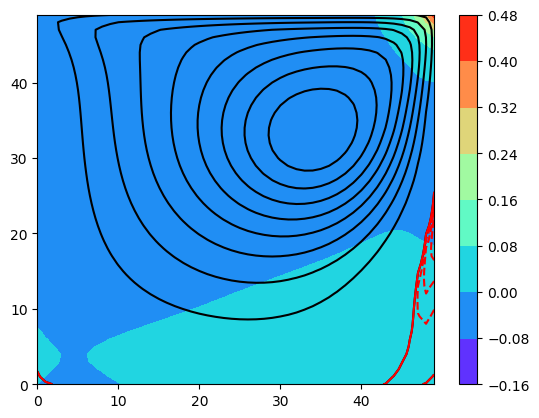

In [16]:
Ψ = streamfunction(uu,vv,1./25,1./25);

pos = linspace(0, maximum(Ψ), 10)
contour(Ψ', pos, colors="black");
neg = linspace(minimum(Ψ), 0, 5)
contourf(pp'; cmap=cmap); colorbar();
contour(Ψ', neg, colors="red");

## Vypočet na nestrukturované síti

Řešíme problém ustáleného obtékání eliptického tělesa v kanále nevazkou nestlačitelnou tekutinou popsanou systémem Navierových-Stokesových rovnic. Při řešení uvažujeme následující okrajové podmínky:
 - levá hranice (vstup): $u=(1,0)$ a $\partial p / \partial n = 0$
 - pravá hranice (výstup): $\partial u/\partial n = 0$ a $p = 0$
 - horní a dolní hranice: $u=(0,0)$ a $\partial p / \partial n = 0$
 - obtékané těleso: $u=(0,0)$ a $\partial p / \partial n = 0$
 
obrázek oblasti viz níže

In [17]:
include("gmsh_mesh.jl")

gmsh_mesh (generic function with 1 method)

In [18]:
gmsh = gmsh_mesh("domain.msh");

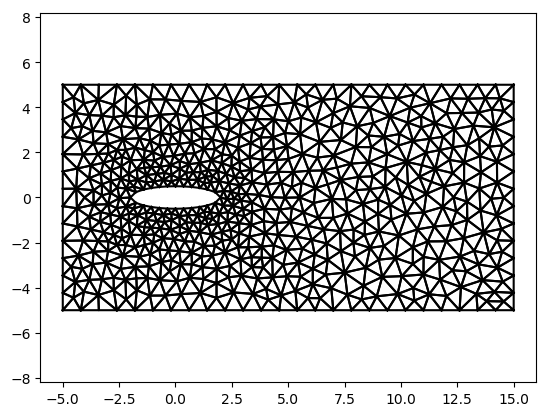

In [19]:
plot_mesh(gmsh);
axis("equal");

In [20]:
keys(gmsh.patches)

Base.KeyIterator for a Dict{String,Array{Face,1}} with 5 entries. Keys:
  "PROFILE"
  "BOTTOM"
  "INLET"
  "OUTLET"
  "TOP"

In [21]:
U = VectorField(gmsh)
set_dirichlet_patch!(U, "INLET", Vec2d(1,0));
set_dirichlet_patch!(U, "TOP", Vec2d(0,0));
set_dirichlet_patch!(U, "BOTTOM", Vec2d(0,0));
set_dirichlet_patch!(U, "PROFILE", Vec2d(0,0));
set_neumann_patch!(U, "OUTLET", Vec2d(0,0));
U.values = [Vec2d(1,0) for c in gmsh.cells]

p = ScalarField(gmsh);
for name ∈ ["INLET", "PROFILE", "TOP", "BOTTOM"]
    set_neumann_patch!(p, name, 0.0)
end
set_dirichlet_patch!(p, "OUTLET", 0.0);

In [22]:
U,p = SIMPLE(U, p, 1.e-3, fix_pressure=false, iters=100);

0	0.013200647550676119	0.0023074718509579536
5	0.00802833169108609	0.0005953211697410497
10	0.003592763303329061	0.00037123646477498715
15	0.0009435004753180898	0.0001496983687921205
20	0.00028389945189824425	6.17076280581715e-5
25	0.0002641171732842298	2.4679940952929288e-5
30	5.800198424025534e-5	1.3214375203445906e-5
35	1.2634339558853555e-5	6.464143263011834e-6
40	8.279055380960016e-6	2.8733216737416483e-6
45	3.7581621238842395e-6	1.546553665626458e-6
50	1.780497887282092e-6	8.863326173832658e-7
55	1.1107180544338645e-6	5.977561343323259e-7
60	9.044482283798151e-7	3.796925903309726e-7
65	6.647126902784963e-7	2.500772544133857e-7
70	2.93334273877108e-7	1.7652846859915782e-7
75	1.2317469295945e-7	1.2985302179154637e-7
80	1.1658603521008567e-7	9.291755076063619e-8
85	6.603097281888303e-8	6.835818384494032e-8
90	4.145791338016993e-8	5.0695350388132073e-8
95	3.0719380727808005e-8	3.769858268100916e-8
100	2.2712135600824893e-8	2.812245539420862e-8


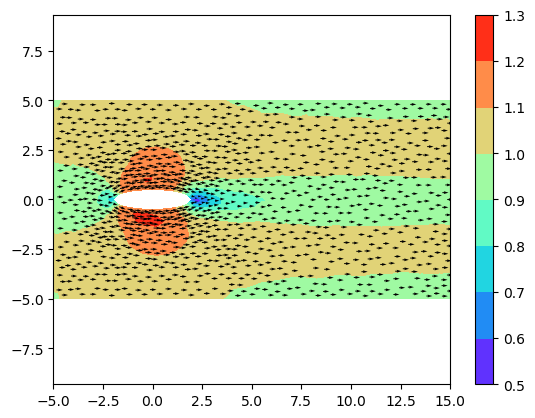

In [23]:
plot_contourf(U; cmap=cmap); colorbar();
plot_arrows(U);
axis("equal");

## Výpočet na síti se zjemněním u stěny

In [24]:
gmf = gmsh_mesh("domain_bl.msh");

In [25]:
#plot_mesh(gmf);
#axis("equal");
#xlim(-1.5,0); ylim(-0.1,1.1);

In [26]:
length(gmf.cells)

3988

In [27]:
keys(gmf.patches)

Base.KeyIterator for a Dict{String,Array{Face,1}} with 5 entries. Keys:
  "PROFILE"
  "BOTTOM"
  "INLET"
  "OUTLET"
  "TOP"

In [28]:
Uf = VectorField(gmf)
set_dirichlet_patch!(Uf, "INLET", Vec2d(1,0));
set_dirichlet_patch!(Uf, "TOP", Vec2d(0,0));
set_dirichlet_patch!(Uf, "BOTTOM", Vec2d(0,0));
set_dirichlet_patch!(Uf, "PROFILE", Vec2d(0,0));
set_neumann_patch!(Uf, "OUTLET", Vec2d(0,0));
Uf.values = [Vec2d(1,0) for c in gmf.cells]

pf = ScalarField(gmf);
for name ∈ ["INLET", "PROFILE", "TOP", "BOTTOM"]
    set_neumann_patch!(pf, name, 0.0)
end
set_dirichlet_patch!(pf, "OUTLET", 0.0);

In [29]:
Uf,pf = SIMPLE(Uf, pf, 1.e-2, fix_pressure=false, iters=10);

0	0.03858972648054848	0.0017800536137290743
5	0.019356777929100573	0.0006796930119210208
10	0.005675544667418447	0.0005761775772204958


In [30]:
Uf,pf = SIMPLE(Uf, pf, 1.e-3, fix_pressure=false, iters=50);

0	0.0027439895791331144	0.0007287874017782792
5	0.001143028087698327	0.0004799918024761333
10	0.00046038682427875736	0.0002610821293495025
15	0.00012527325456790752	0.00014093897905313626
20	9.44321427596987e-5	8.961099486556899e-5
25	4.5074120444983484e-5	6.056895512282779e-5
30	1.9753486398561668e-5	3.9730684661777746e-5
35	6.956636340000575e-6	2.4663815327495277e-5
40	6.401183310854372e-6	1.5276897893690237e-5
45	3.6745924915838055e-6	9.664242565034637e-6
50	2.095087267901909e-6	6.715758778567062e-6


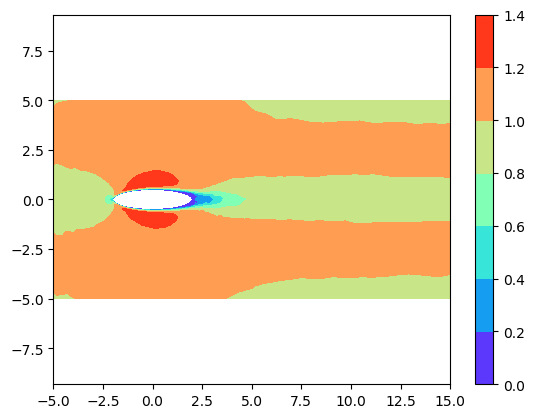

In [31]:
plot_contourf(Uf; cmap=cmap); colorbar();
#plot_arrows(Uf);
axis("equal");

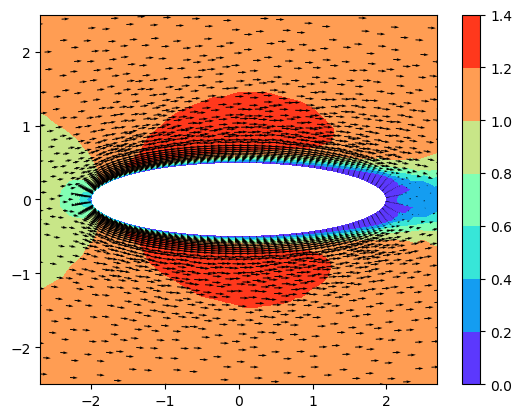

In [32]:
plot_contourf(Uf; cmap=cmap); colorbar();
plot_arrows(Uf; units="xy", scale=10);
axis("equal");
xlim(-1.5,1.5); ylim(-2.5,2.5);